<a href="https://colab.research.google.com/github/minseung5621/YOLOv8-/blob/main/YOLOv8_%EA%B8%B0%EB%B0%98_%EB%8F%84%EB%A1%9C_%ED%91%9C%EC%A7%80%ED%8C%90_%ED%83%90%EC%A7%80_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip -q install ultralytics kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d andrewmvd/road-sign-detection -p /content --unzip
!ls -al /content


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 72% 156M/218M [00:00<00:00, 1.62GB/s]
100% 218M/218M [00:00<00:00, 937MB/s] 
total 223456
drwxr-xr-x 1 root root      4096 Jan  7 15:26 .
drwxr-xr-x 1 root root      4096 Jan  7 15:02 ..
drwxr-xr-x 2 root root     36864 Jan  7 15:26 annotations
-rw-r--r-- 1 root root 228716498 Jan  7 15:18 archive.zip
drwxr-xr-x 4 root root      4096 Dec  9 14:41 .config
drwxr-xr-x 2 root root     36864 Jan  7 15:26 images
-rw-r--r-- 1 root root        67 Jan  7 15:26 kaggle.json
drwxr-xr-x 1 root root      4096 Dec  9 14:42 sample_data


In [6]:
!mkdir -p /content/datasets/roadsign/images/train /content/datasets/roadsign/images/val
!mkdir -p /content/datasets/roadsign/labels/train /content/datasets/roadsign/labels/val


In [7]:
import os, glob, shutil, random, xml.etree.ElementTree as ET
from pathlib import Path

random.seed(0)

# 1) 원본 경로(너의 폴더 구조에 맞게 필요하면 수정)
# 아래는 흔한 예시: images 폴더와 annotations(xml) 폴더가 따로 있는 경우
IMG_DIR_CANDIDATES = [
    "/content/images",
    "/content/road-sign-detection/images",
    "/content/Road_Sign_Detection/images",
    "/content"
]
ANN_DIR_CANDIDATES = [
    "/content/annotations",
    "/content/road-sign-detection/annotations",
    "/content/Road_Sign_Detection/annotations",
    "/content"
]

def find_dir_with(patterns, exts):
    for base in patterns:
        if not os.path.exists(base):
            continue
        for ext in exts:
            if glob.glob(os.path.join(base, "**", f"*{ext}"), recursive=True):
                return base
    return None

img_base = find_dir_with(IMG_DIR_CANDIDATES, [".jpg", ".png", ".jpeg"])
ann_base = find_dir_with(ANN_DIR_CANDIDATES, [".xml"])

print("img_base:", img_base)
print("ann_base:", ann_base)

assert img_base is not None, "이미지 폴더를 못 찾았어요. find 결과를 보고 IMG_DIR_CANDIDATES를 수정하세요."
assert ann_base is not None, "XML 어노테이션을 못 찾았어요. find 결과를 보고 ANN_DIR_CANDIDATES를 수정하세요."

# 2) 파일 리스트 수집
images = glob.glob(os.path.join(img_base, "**", "*.jpg"), recursive=True) + \
         glob.glob(os.path.join(img_base, "**", "*.png"), recursive=True) + \
         glob.glob(os.path.join(img_base, "**", "*.jpeg"), recursive=True)

xmls = glob.glob(os.path.join(ann_base, "**", "*.xml"), recursive=True)

print("num images:", len(images))
print("num xmls:", len(xmls))

# 3) XML에서 클래스명 수집 (names 만들기)
classes = set()
for x in xmls:
    root = ET.parse(x).getroot()
    for obj in root.findall("object"):
        name = obj.find("name").text.strip()
        classes.add(name)

classes = sorted(list(classes))
class2id = {c:i for i,c in enumerate(classes)}
print("classes:", classes)

# 4) XML → YOLO 변환 함수
def convert_box(size, box):
    w, h = size
    xmin, ymin, xmax, ymax = box
    x = (xmin + xmax) / 2.0 / w
    y = (ymin + ymax) / 2.0 / h
    bw = (xmax - xmin) / w
    bh = (ymax - ymin) / h
    return x, y, bw, bh

# 5) 이미지 파일명 기준으로 xml 매칭
xml_map = {Path(x).stem: x for x in xmls}

pairs = []
for im in images:
    stem = Path(im).stem
    if stem in xml_map:
        pairs.append((im, xml_map[stem]))

print("matched pairs:", len(pairs))
assert len(pairs) > 0, "이미지와 XML 매칭이 안 됩니다(파일명 기준). 데이터셋 구조를 확인하세요."

# 6) train/val split
random.shuffle(pairs)
split = int(len(pairs) * 0.8)
train_pairs = pairs[:split]
val_pairs = pairs[split:]

OUT = Path("/content/datasets/roadsign")
def process_split(pairs, split_name):
    for im_path, xml_path in pairs:
        # copy image
        dst_img = OUT / "images" / split_name / Path(im_path).name
        shutil.copy2(im_path, dst_img)

        # parse xml
        root = ET.parse(xml_path).getroot()
        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        lines = []
        for obj in root.findall("object"):
            cls = obj.find("name").text.strip()
            cls_id = class2id[cls]
            bnd = obj.find("bndbox")
            xmin = float(bnd.find("xmin").text)
            ymin = float(bnd.find("ymin").text)
            xmax = float(bnd.find("xmax").text)
            ymax = float(bnd.find("ymax").text)
            x, y, bw, bh = convert_box((w,h), (xmin,ymin,xmax,ymax))
            lines.append(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}")

        dst_lbl = OUT / "labels" / split_name / (Path(im_path).stem + ".txt")
        dst_lbl.write_text("\n".join(lines))

process_split(train_pairs, "train")
process_split(val_pairs, "val")

print("done.")
print("train imgs:", len(list((OUT/'images/train').glob('*'))))
print("val imgs:", len(list((OUT/'images/val').glob('*'))))


img_base: /content/images
ann_base: /content/annotations
num images: 877
num xmls: 877
classes: ['crosswalk', 'speedlimit', 'stop', 'trafficlight']
matched pairs: 877
done.
train imgs: 701
val imgs: 176


In [8]:
from pathlib import Path
import yaml

data = {
    "path": "/content/datasets/roadsign",
    "train": "images/train",
    "val": "images/val",
    "names": {i:name for i,name in enumerate(classes)}
}

Path("/content/datasets/roadsign/data.yaml").write_text(yaml.dump(data, sort_keys=False, allow_unicode=True))
print(Path("/content/datasets/roadsign/data.yaml").read_text())


path: /content/datasets/roadsign
train: images/train
val: images/val
names:
  0: crosswalk
  1: speedlimit
  2: stop
  3: trafficlight



In [9]:
from pathlib import Path
import yaml

classes = yaml.safe_load(open("/content/datasets/roadsign_tmp_classes.yaml","w")) if False else None


In [10]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # yolov8n.pt로 더 빠르게 가능
model.train(
    data="/content/datasets/roadsign/data.yaml",
    epochs=10,
    imgsz=640,
    batch=16,   # T4에서 무난
    name="roadsign_y8s"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/roadsign/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79264c16f950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [11]:
from ultralytics import YOLO
model = YOLO("/content/runs/detect/roadsign_y8s/weights/best.pt")


In [12]:
results = model.predict(
    source="/content/datasets/roadsign/images/val",
    imgsz=640,
    conf=0.25,
    save=True,
    name="roadsign_pred"
)



image 1/176 /content/datasets/roadsign/images/val/road11.png: 480x640 2 trafficlights, 42.3ms
image 2/176 /content/datasets/roadsign/images/val/road117.png: 384x640 1 speedlimit, 43.1ms
image 3/176 /content/datasets/roadsign/images/val/road124.png: 640x544 1 crosswalk, 1 trafficlight, 42.6ms
image 4/176 /content/datasets/roadsign/images/val/road13.png: 640x448 3 trafficlights, 43.0ms
image 5/176 /content/datasets/roadsign/images/val/road135.png: 416x640 (no detections), 42.4ms
image 6/176 /content/datasets/roadsign/images/val/road14.png: 640x448 1 trafficlight, 12.5ms
image 7/176 /content/datasets/roadsign/images/val/road140.png: 448x640 1 crosswalk, 42.8ms
image 8/176 /content/datasets/roadsign/images/val/road147.png: 384x640 1 crosswalk, 11.3ms
image 9/176 /content/datasets/roadsign/images/val/road163.png: 640x480 1 speedlimit, 40.6ms
image 10/176 /content/datasets/roadsign/images/val/road165.png: 640x480 2 crosswalks, 12.1ms
image 11/176 /content/datasets/roadsign/images/val/road17

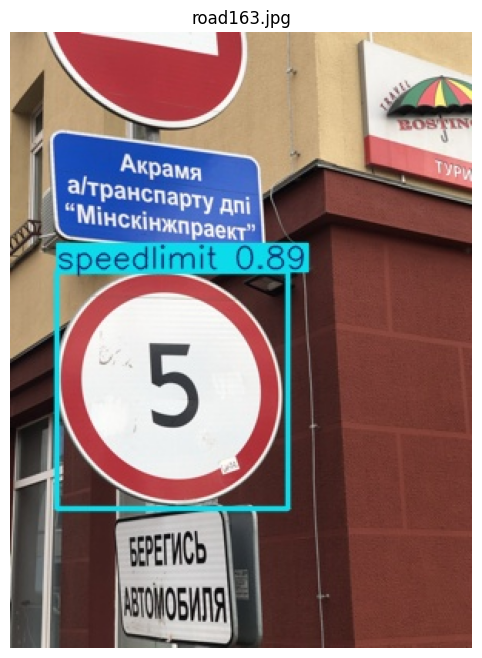

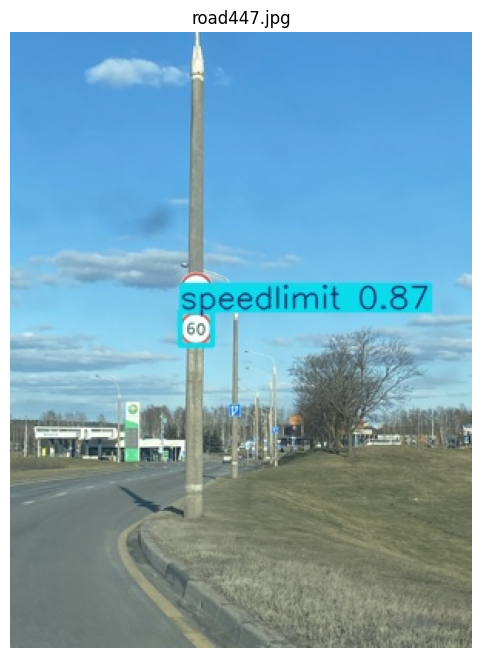

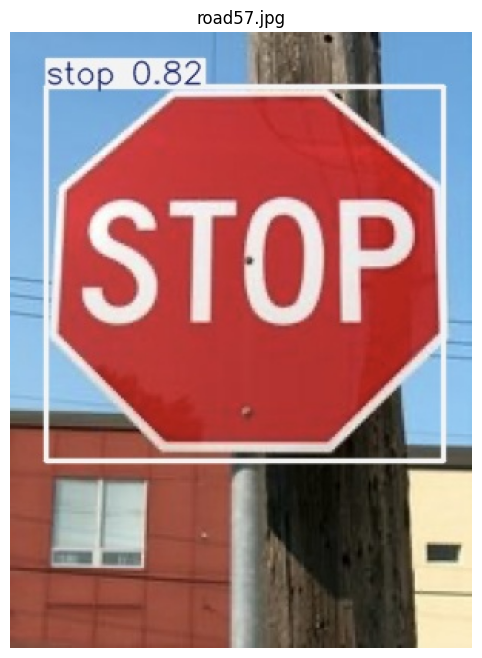

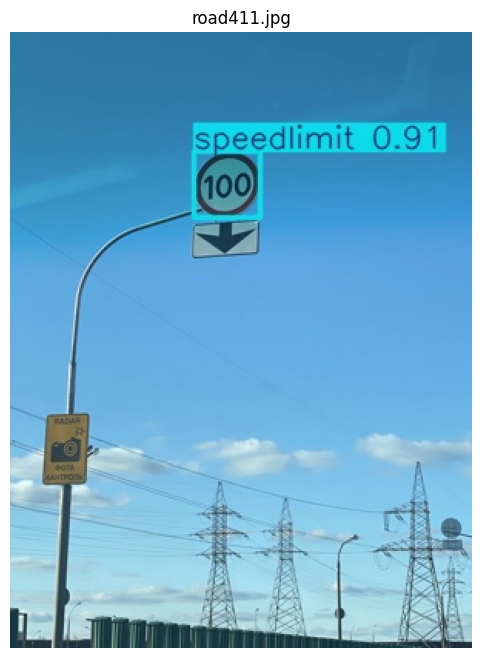

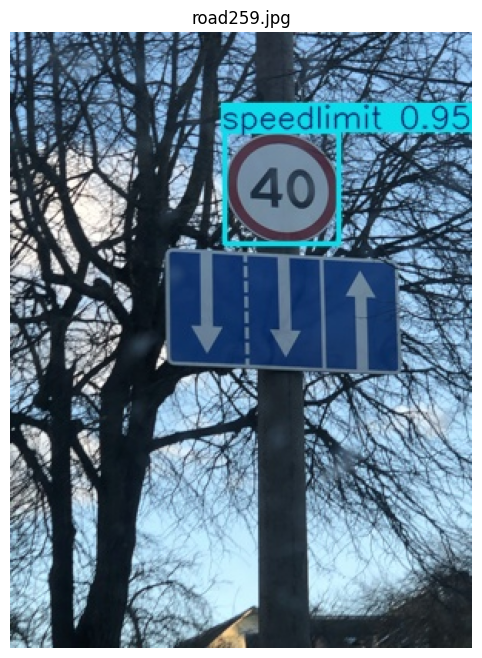

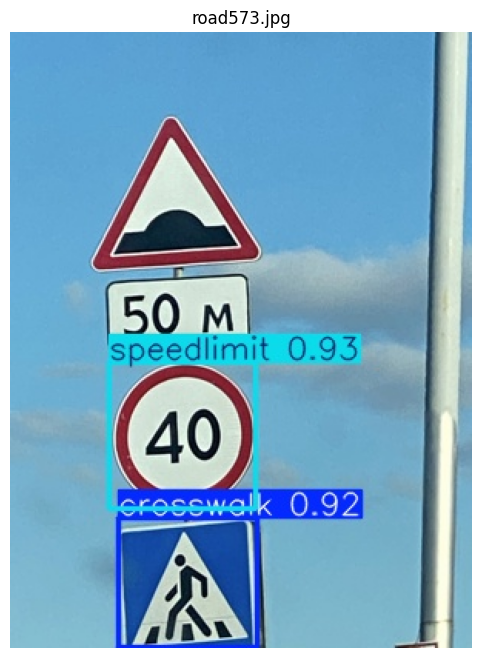

In [13]:
import glob
from PIL import Image
from matplotlib import pyplot as plt

pred_imgs = glob.glob("/content/runs/detect/roadsign_pred/*.jpg") + glob.glob("/content/runs/detect/roadsign_pred/*.png")
pred_imgs = pred_imgs[:6]

for p in pred_imgs:
    img = Image.open(p)
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(p.split("/")[-1])
    plt.show()
